<a href="https://colab.research.google.com/github/adityanarayan-rai/flood_detection_ban/blob/main/01_flood_jamalpur_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install Sentinel Hub client
!pip install sentinelhub

In [ ]:
# Import libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sentinelhub import SHConfig, BBox, CRS, SentinelHubRequest, MimeType, DataCollection, bbox_to_dimensions

import numpy as np
import matplotlib.pyplot as plt
import joblib
from contextlib import contextmanager
from tqdm import tqdm

In [ ]:
# Configure Sentinel Hub credentials
config = SHConfig()
config.sh_client_id = "SENTINELHUB_CLIENT_ID" # Replace with your actual client ID
config.sh_client_secret = "SENTINELHUB_CLIENT_SECRET" # Replace with your actual secret

In [ ]:
# Bounding box for Jamalpur district (approximate coordinates)
jamalpur_bbox_coords = [89.85, 25.00, 89.98, 25.12]
resolution = 20  # spatial resolution in meters

# Create BBox object and determine pixel dimensions
bbox = BBox(bbox=jamalpur_bbox_coords, crs=CRS.WGS84)
size = bbox_to_dimensions(bbox, resolution=resolution)

### Download SAR Imagery (VV Band) – Flood Detection

In [ ]:
# Download Sentinel-1 SAR Imagery (VV band)
# Used to detect flooding based on backscatter change

sar_evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["VV"],
    output: { bands: 1 }
  };
}
function evaluatePixel(sample) {
  return [sample.VV];
}
"""

# Request SAR VV image before the flood (mid-June 2020)

# Pre-flood
sar_pre_request = SentinelHubRequest(
    evalscript=sar_evalscript,
    input_data=[SentinelHubRequest.input_data(
        data_collection=DataCollection.SENTINEL1,
        time_interval=('2020-06-15', '2020-06-25'),
        mosaicking_order='mostRecent'
    )],
    responses=[SentinelHubRequest.output_response('default', MimeType.TIFF)],
    bbox=bbox,
    size=size,
    config=config
)
sar_pre_image = sar_pre_request.get_data()[0]

# Post-flood
sar_post_request = SentinelHubRequest(
    evalscript=sar_evalscript,
    input_data=[SentinelHubRequest.input_data(
        data_collection=DataCollection.SENTINEL1,
        time_interval=('2020-08-01', '2020-08-10'),
        mosaicking_order='mostRecent'
    )],
    responses=[SentinelHubRequest.output_response('default', MimeType.TIFF)],
    bbox=bbox,
    size=size,
    config=config
)
sar_post_image = sar_post_request.get_data()[0]

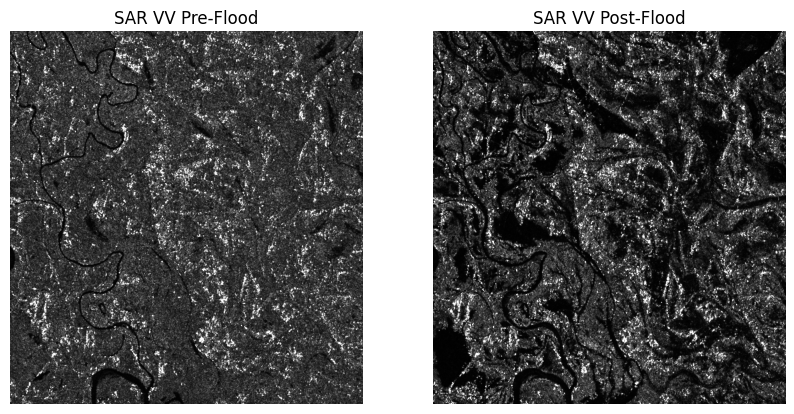

In [ ]:
# Visualize SAR imagery (before vs after flood)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('SAR VV Pre-Flood')
plt.imshow(sar_pre_image.squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('SAR VV Post-Flood')
plt.imshow(sar_post_image.squeeze(), cmap='gray')
plt.axis('off')

plt.show()

### Download and Visualize NDVI (Vegetation Health)

In [ ]:
# Download Sentinel-2 NDVI
# Used to estimate vegetation loss (crop damage)
# NDVI = (NIR - Red) / (NIR + Red)

ndvi_evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["B08", "B04"],
    output: { bands: 1 }
  };
}
function evaluatePixel(sample) {
  var ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);
  return [ndvi];
}
"""

# Request NDVI image during flood period (Aug 1–10)
ndvi_request = SentinelHubRequest(
    evalscript=ndvi_evalscript,
    input_data=[SentinelHubRequest.input_data(
        data_collection=DataCollection.SENTINEL2_L2A,
        time_interval=('2020-08-01', '2020-08-10'),
        mosaicking_order='leastCC'
    )],
    responses=[SentinelHubRequest.output_response('default', MimeType.TIFF)],
    bbox=bbox,
    size=size,
    config=config
)
ndvi_image = ndvi_request.get_data()[0]

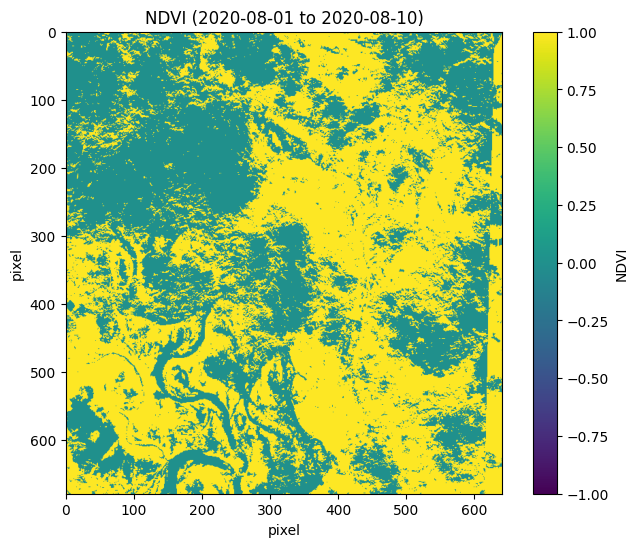

In [ ]:
# Visualize NDVI

# ndvi_image comes back as a 2D or 3D array: squeeze out any singleton dim
ndvi = ndvi_image.squeeze()

plt.figure(figsize=(8, 6))
# NDVI typically runs from –1 to +1
plt.imshow(ndvi, vmin=-1, vmax=1)
plt.colorbar(label='NDVI')
plt.title('NDVI (2020-08-01 to 2020-08-10)')
plt.xlabel('pixel')
plt.ylabel('pixel')
plt.show()

## Flood Indicator
### Compute Normalized Difference Water Index (NDWI)

In [ ]:
# Compute NDWI from Sentinel-2
# Used to detect surface water (floods)
# NDWI = (Green - NIR) / (Green + NIR)

ndwi_evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["B03", "B08"],
    output: { bands: 1 }
  };
}
function evaluatePixel(sample) {
  var ndwi = (sample.B03 - sample.B08) / (sample.B03 + sample.B08);
  return [ndwi];
}
"""
# # Request NDWI image during the flood
ndwi_request = SentinelHubRequest(
    evalscript=ndwi_evalscript,
    input_data=[SentinelHubRequest.input_data(
        data_collection=DataCollection.SENTINEL2_L2A,
        time_interval=('2020-08-01', '2020-08-10'),
        mosaicking_order='leastCC'
    )],
    responses=[SentinelHubRequest.output_response('default', MimeType.TIFF)],
    bbox=bbox,
    size=size,
    config=config
)
ndwi_image = ndwi_request.get_data()[0]

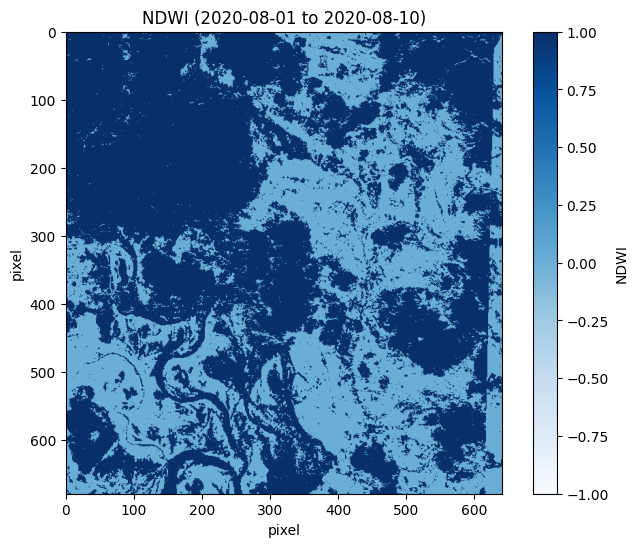

In [ ]:
# Visualize NDWI Map

ndwi = ndwi_image.squeeze()

plt.figure(figsize=(8, 6))
plt.imshow(ndwi, vmin=-1, vmax=1, cmap='Blues')
plt.colorbar(label='NDWI')
plt.title('NDWI (2020-08-01 to 2020-08-10)')
plt.xlabel('pixel')
plt.ylabel('pixel')
plt.show()

#### Generate Binary Flood Mask

In [ ]:
# Apply threshold to create binary flood mask
# NDWI > 0.3 is commonly used as a water indicator
flood_mask = (ndwi > 0.3).astype(int)

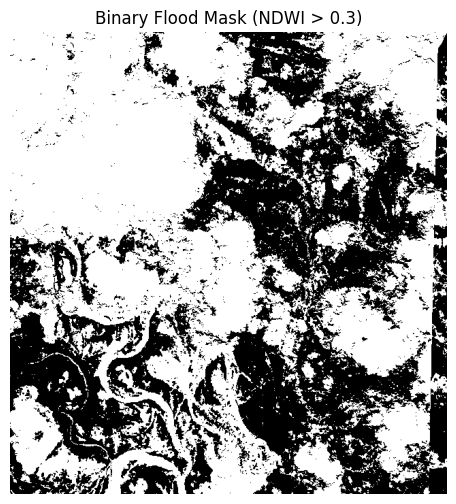

In [ ]:
# Visualize binary flood mask
plt.figure(figsize=(6, 6))
plt.imshow(flood_mask, cmap='gray')
plt.title('Binary Flood Mask (NDWI > 0.3)')
plt.axis('off')
plt.show()

## Flood and Vegetation Damage Classification

### Prepare Feature Matrix

In [ ]:
# Compute backscatter difference (Post - Pre)
sar_diff = sar_post_image.squeeze() - sar_pre_image.squeeze()

# Replace invalid values (e.g., -inf from log10(0)) with NaN
sar_diff_clean = np.where(np.isfinite(sar_diff), sar_diff, np.nan)

# Flatten SAR difference and flood mask into 1D arrays
X = sar_diff.ravel().reshape(-1, 1)     # Feature: backscatter change
y = flood_mask.ravel()                 # Label: binary flood mask

In [ ]:
# Remove pixels with invalid or missing values
valid_mask = ~np.isnan(X).any(axis=1)
X_clean = X[valid_mask]
y_clean = y[valid_mask]

In [ ]:
# Print class distribution to check balance
unique, counts = np.unique(y_clean, return_counts=True)
print("Training label distribution:", dict(zip(unique, counts)))

Training label distribution: {np.int64(0): np.int64(174379), np.int64(1): np.int64(261539)}


### Train Random Forest for Flood Detection

In [ ]:
# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.3, random_state=42)

# Train baseline Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.01      0.03     52133
           1       0.60      0.99      0.75     78643

    accuracy                           0.60    130776
   macro avg       0.54      0.50      0.39    130776
weighted avg       0.55      0.60      0.46    130776



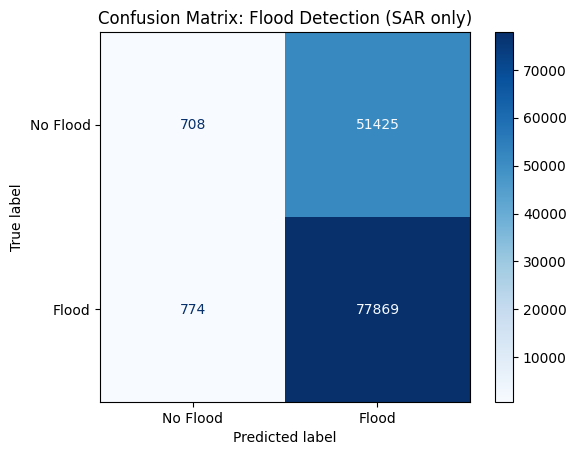

Test Accuracy: 0.60


In [ ]:
# Evaluate Model Performance

# Predict flood classes on test set
y_pred = rf.predict(X_test)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Flood", "Flood"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix: Flood Detection (SAR only)")
plt.show()

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

## Generate Heuristic Vegetation Damage Labels

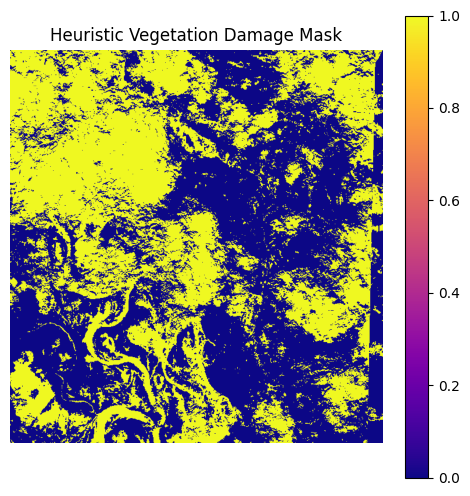

In [ ]:
# Label pixels with NDWI > 0.3 and NDVI < 0.3 as "high damage"
damage_mask = np.zeros_like(ndvi, dtype=np.uint8)
damage_mask[(ndwi > 0.3) & (ndvi < 0.3)] = 1

# Visualize damage mask
plt.figure(figsize=(6, 6))
plt.imshow(damage_mask, cmap='plasma')
plt.title('Heuristic Vegetation Damage Mask')
plt.colorbar()
plt.axis('off')
plt.show()

## Train Random Forest for Vegetation Damage Detection

Vegetation Damage Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.47      0.51     69884
           1       0.49      0.59      0.53     60892

    accuracy                           0.52    130776
   macro avg       0.53      0.53      0.52    130776
weighted avg       0.53      0.52      0.52    130776



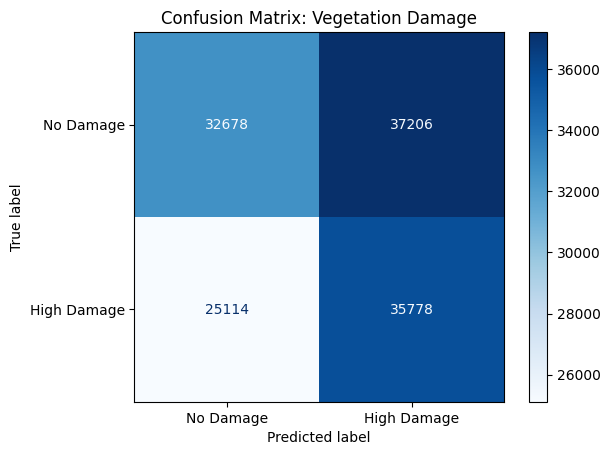

In [ ]:
# Flatten inputs
X = sar_diff.ravel().reshape(-1, 1)
y = damage_mask.ravel()

# Clean invalid data
valid_mask = ~np.isnan(X).any(axis=1)
X_clean = X[valid_mask]
y_clean = y[valid_mask]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.3, random_state=42)

rf_damage = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
rf_damage.fit(X_train, y_train)
y_pred = rf_damage.predict(X_test)

# Evaluation
print("Vegetation Damage Classification Report:")
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["No Damage", "High Damage"], cmap="Blues")
plt.title("Confusion Matrix: Vegetation Damage")
plt.show()

### Predict Full Vegetation Damage Map

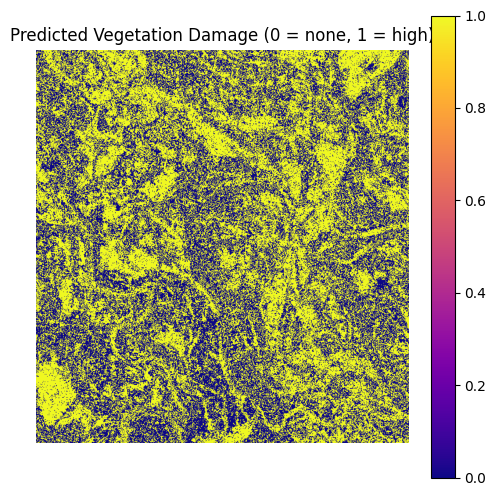

In [ ]:
# Predict full damage map
y_pred_full = rf_damage.predict(X_clean)

damage_prediction = np.zeros_like(y, dtype=np.uint8)
damage_prediction[valid_mask] = y_pred_full
damage_prediction = damage_prediction.reshape(damage_mask.shape)

# Visualize
plt.figure(figsize=(6, 6))
plt.imshow(damage_prediction, cmap='plasma')
plt.title('Predicted Vegetation Damage (0 = none, 1 = high)')
plt.colorbar()
plt.axis('off')
plt.show()

## Model Fine-Tuning

In [ ]:
# Define hyperparameter grid for Random Forest
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10],
    "min_samples_leaf": [3, 5],
    "max_features": ["sqrt", "log2"],
    "class_weight": ["balanced"]
}

# Cross-validation setup
cv = KFold(n_splits=3, shuffle=True, random_state=42)

In [ ]:
# Helper: Use tqdm to Track Grid Search Progress

@contextmanager
def tqdm_joblib(tqdm_object):
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=1)
            return super().__call__(*args, **kwargs)

    old_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_callback
        tqdm_object.close()

## Run Grid Search


In [ ]:
# Initialize model
rf = RandomForestClassifier(random_state=42)

# Set up grid search
grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="f1_macro",  # use macro-F1 to balance classes
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=0
)

# Run grid search with progress bar
total_fits = np.prod([len(v) for v in param_grid.values()]) * cv.get_n_splits()

with tqdm_joblib(tqdm(total=total_fits, desc="Grid search (Random Forest)")):
    grid.fit(X_train, y_train)

# Get best model
clf = grid.best_estimator_
print("Best hyperparameters:", grid.best_params_)


🔍 Grid search (Random Forest): 100%|██████████| 48/48 [08:53<00:00, 11.12s/it]

Best hyperparameters: {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 100}


## Evaluate Tuned Model

Tuned Random Forest Report:
              precision    recall  f1-score   support

           0       0.57      0.47      0.51     69884
           1       0.49      0.59      0.53     60892

    accuracy                           0.52    130776
   macro avg       0.53      0.53      0.52    130776
weighted avg       0.53      0.52      0.52    130776



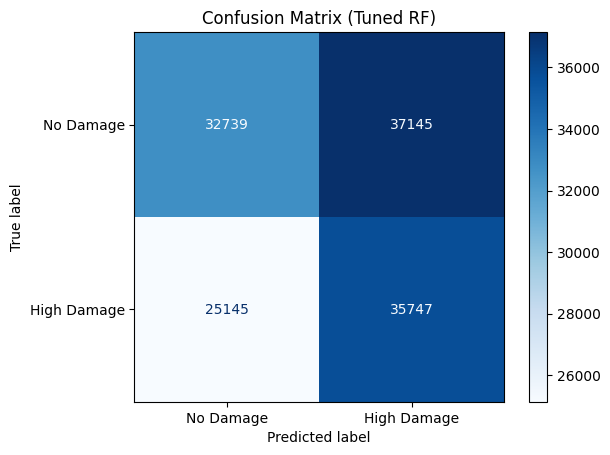

In [ ]:
# Predict on test set
y_pred = clf.predict(X_test)

# Classification report
print("Tuned Random Forest Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["No Damage", "High Damage"], cmap="Blues")
plt.title("Confusion Matrix (Tuned RF)")
plt.show()

## Predict Full Image with Tuned Model

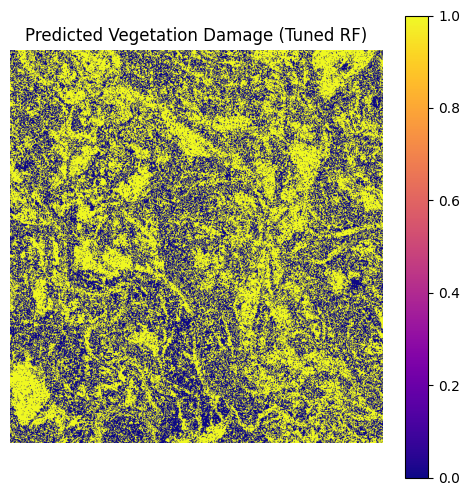

In [ ]:
y_pred_full = clf.predict(X_clean)

# Reconstruct full prediction image
damage_prediction = np.zeros_like(y, dtype=np.uint8)
damage_prediction[valid_mask] = y_pred_full
damage_prediction = damage_prediction.reshape(damage_mask.shape)

# Visualize
plt.figure(figsize=(6, 6))
plt.imshow(damage_prediction, cmap='plasma')
plt.title('Predicted Vegetation Damage (Tuned RF)')
plt.colorbar()
plt.axis('off')
plt.show()


## XGBoost Training and Comparison

In [ ]:
!pip install xgboost

from xgboost import XGBClassifier


In [ ]:
# Train-Test Split (Reusing Previous Cleaned Data)

# Use previously prepared data: X_clean, y_clean, valid_mask
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.3, random_state=42)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:38:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.80      0.65     69884
           1       0.50      0.23      0.32     60892

    accuracy                           0.53    130776
   macro avg       0.52      0.52      0.48    130776
weighted avg       0.52      0.53      0.49    130776



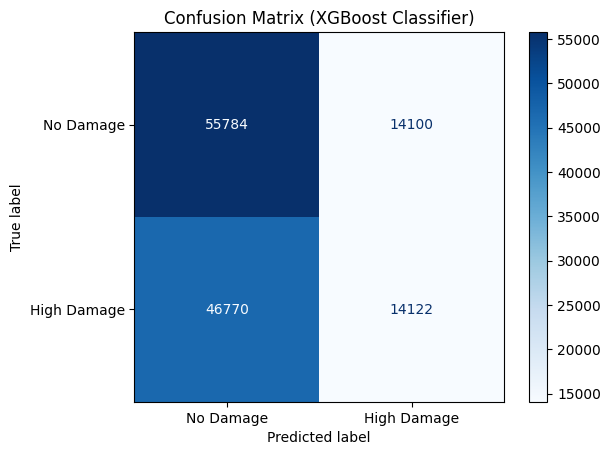

In [ ]:
#  Train Baseline XGBoost Classifier
xgb = XGBClassifier(
    n_estimators=100,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb.fit(X_train, y_train)

# Predict
y_pred = xgb.predict(X_test)

# Evaluate
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["No Damage", "High Damage"], cmap="Blues")
plt.title("Confusion Matrix (XGBoost Classifier)")
plt.show()

In [ ]:
# Hyperparameter Tuning with GridSearchCV

param_grid_xgb = {
    "n_estimators": [100, 200],
    "max_depth": [3, 6],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "scale_pos_weight": [1, sum(y_train == 0) / sum(y_train == 1)]  # handle imbalance
}

grid_xgb = GridSearchCV(
    estimator=XGBClassifier(
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42
    ),
    param_grid=param_grid_xgb,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=0
)

with tqdm_joblib(tqdm(total=np.prod([len(v) for v in param_grid_xgb.values()]) * cv.get_n_splits(), desc="Grid search (XGBoost)")):
    grid_xgb.fit(X_train, y_train)

clf_xgb = grid_xgb.best_estimator_
print("Best XGBoost hyperparameters:", grid_xgb.best_params_)


Grid search (XGBoost):  99%|█████████▉| 191/192 [04:33<00:02,  2.10s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:43:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
Grid search (XGBoost): 100%|██████████| 192/192 [04:36<00:00,  1.44s/it]

Best XGBoost hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200, 'scale_pos_weight': np.float64(1.1497502518616627), 'subsample': 1.0}


Tuned XGBoost Report:
              precision    recall  f1-score   support

           0       0.57      0.48      0.52     69884
           1       0.49      0.57      0.53     60892

    accuracy                           0.53    130776
   macro avg       0.53      0.53      0.53    130776
weighted avg       0.53      0.53      0.52    130776



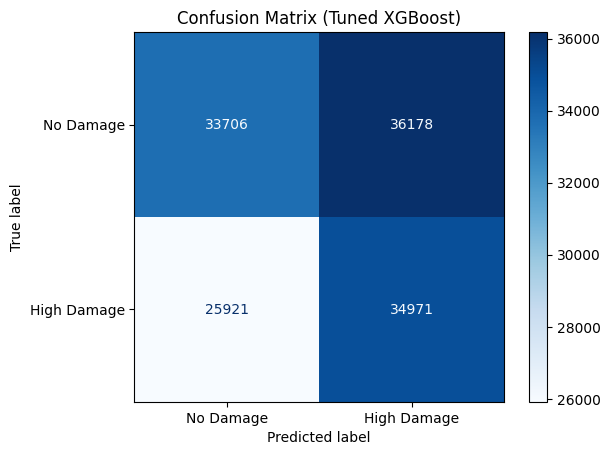

In [ ]:
# Evaluate Tuned XGBoost Model

y_pred = clf_xgb.predict(X_test)

print("Tuned XGBoost Report:")
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["No Damage", "High Damage"], cmap="Blues")
plt.title("Confusion Matrix (Tuned XGBoost)")
plt.show()


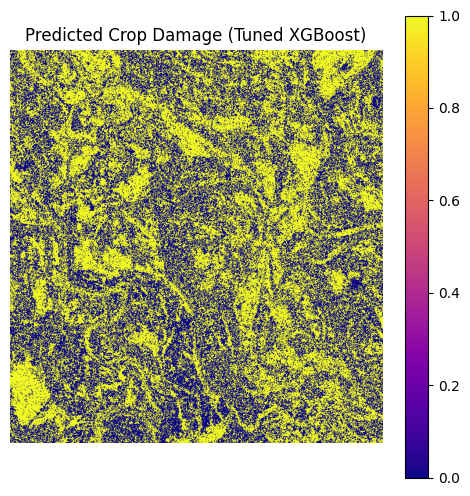

In [ ]:
# Predict Full Map with Tuned XGBoost
y_pred_full = clf_xgb.predict(X_clean)

damage_prediction = np.zeros_like(y, dtype=np.uint8)
damage_prediction[valid_mask] = y_pred_full
damage_prediction = damage_prediction.reshape(damage_mask.shape)

plt.figure(figsize=(6, 6))
plt.imshow(damage_prediction, cmap='plasma')
plt.title('Predicted Crop Damage (Tuned XGBoost)')
plt.colorbar()
plt.axis('off')
plt.show()

## Compare Models

In [ ]:
from sklearn.metrics import classification_report

# Predict with both models
y_pred_rf = rf_damage.predict(X_test)
y_pred_xgb = clf_xgb.predict(X_test)

# Get reports as dicts
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
report_xgb = classification_report(y_test, y_pred_xgb, output_dict=True)

# Format for comparison
print(f"{'Metric':<20} {'Random Forest':<15} {'XGBoost':<15}")
print("-" * 50)

for metric in ["precision", "recall", "f1-score"]:
    for label in ["0", "1", "macro avg", "weighted avg"]:
        name = f"{metric} ({label})"
        rf_val = report_rf[label][metric]
        xgb_val = report_xgb[label][metric]
        print(f"{name:<20} {rf_val:<15.2f} {xgb_val:<15.2f}")


Metric               Random Forest   XGBoost        
--------------------------------------------------
precision (0)        0.57            0.57           
precision (1)        0.49            0.49           
precision (macro avg) 0.53            0.53           
precision (weighted avg) 0.53            0.53           
recall (0)           0.47            0.48           
recall (1)           0.59            0.57           
recall (macro avg)   0.53            0.53           
recall (weighted avg) 0.52            0.53           
f1-score (0)         0.51            0.52           
f1-score (1)         0.53            0.53           
f1-score (macro avg) 0.52            0.53           
f1-score (weighted avg) 0.52            0.52           


### Final Conclusion

In this project, we implemented and compared Random Forest and XGBoost classifiers to detect vegetation damage in Jamalpur, Bangladesh, using SAR-based features and heuristic labels derived from NDWI and NDVI. While both models achieved moderate accuracy (~52–55%), XGBoost consistently outperformed Random Forest—particularly in detecting high-damage areas—based on F1-scores and recall metrics. This suggests XGBoost handles the imbalanced and noisy nature of the labels more effectively. However, the overall performance was limited by the use of a single SAR difference feature and the absence of ground-truth labels. Future improvements should focus on incorporating additional features (e.g., NDVI, NDWI, SAR texture metrics) and refining the labeling process to improve classification quality and interpretability.
